In [1]:
from tinyai import *

In [2]:
from datasets import load_dataset

dsd = load_dataset("daloopa/fashion-mnist-interview")

x,y = 'image','label'

bs = 256
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs, num_workers=4)

In [3]:
import matplotlib as mpl

def toggle_mpl():
    if mpl.rcParams['image.cmap'] == 'viridis':
        mpl.rcParams['image.cmap'] = 'gray_r'
    else:
        mpl.rcParams['image.cmap'] = 'viridis'
    print("setting cmap:", mpl.rcParams['image.cmap'])

toggle_mpl()

setting cmap: gray_r


In [4]:
from functools import partial
from torch import nn
from torch import optim

def get_model():
    act = partial(GeneralReLU, leak=0.1, sub=0.4)
    norm = nn.BatchNorm2d
    
    # 14, 7, 4, 2, 1
    hdims = (16, 32, 64, 128, 256)

    layers: list[nn.Module] = [conv(1, hdims[0], ks=5, act=act, norm=norm)] # 14x14
    for fi, fo in zip(hdims, hdims[1:]):
        layers.append(ResBlock(fi, fo, stride=2, act=act, norm=norm))
    layers.append(nn.Sequential(GlobalAvgPool(), nn.Linear(hdims[-1], 10), nn.BatchNorm1d(10)))
    return nn.Sequential(*layers)


def get_learner():
    model = get_model().apply(partial(init_weights, leaky=0.1))
    return Trainer(model, dls, loss_func=cross_entropy, opt_func=optim.AdamW)

In [5]:
learn = get_learner()
learn.summary()

/Users/tom/fun/tinyai/tinyai/nn/functional.py:9: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1694493834224/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  target = F.one_hot(target).to(torch.int32).float()


Tot params: 1224958; MFLOPS: 3.5


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(256, 1, 28, 28)|(256, 16, 14, 14)|448|0.1|
|ResBlock|(256, 16, 14, 14)|(256, 32, 7, 7)|14560|0.7|
|ResBlock|(256, 32, 7, 7)|(256, 64, 4, 4)|57792|0.9|
|ResBlock|(256, 64, 4, 4)|(256, 128, 2, 2)|230272|0.9|
|ResBlock|(256, 128, 2, 2)|(256, 256, 1, 1)|919296|0.9|
|Sequential|(256, 256, 1, 1)|(256, 10)|2590|0.0|


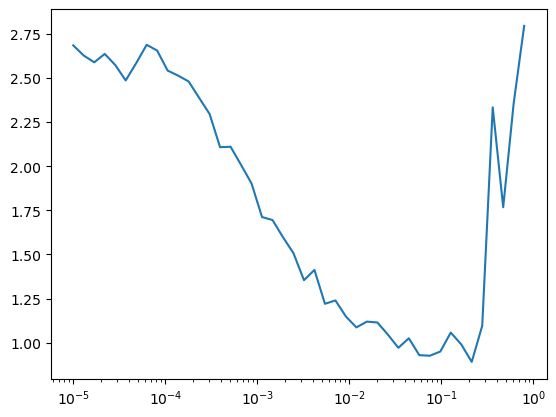

In [11]:
# learn.lr_find()

In [6]:
learn.fit_one_cycle(3, max_lr=8e-2)

[<tinyai.cbs.ToDeviceCB object at 0x283fa6dd0>, <tinyai.cbs.TrainCB object at 0x283fa6d40>, <tinyai.cbs.ProgressCB object at 0x283fa6d70>, <tinyai.cbs.PlotLossCB object at 0x283fa7010>, <tinyai.cbs.BatchSchedCB object at 0x283fa64a0>]


ValueError: Requires callbacks: MetricsCB